In object detection, we perform both bounding box regression and classification. While classification losses are standardized with `Focal Loss`. In bbox regressor, we have seen various improvements from `L1 Loss` and `L2 Loss` over a period of time. We will see what those loss functions are here.
- IoU
- Generalized IoU (GIoU)
- Distance IoU (DIoU)
- Complete IoU (CIoU)

Emperically, CIoU is the SOTA now but lets see everything to understand how we reached here.

> Lets take two examples to understand different loss functions
- gt and pred boxes overlapped 
- gt and pred boxes with no overlap

> Let's write some utility functions to visualize the bbox

In [1]:
import torch 
import torchvision
import numpy as np 
from PIL import Image, ImageDraw
from pydantic import BaseModel, confloat, conint

In [2]:
class Bbox(BaseModel):
    # Bbox placeholder
    xmin: confloat(ge=0)
    ymin: confloat(ge=0)
    xmax: confloat(ge=0)
    ymax: confloat(ge=0)
    
    @property
    def ctr(self):
        xctr = self.xmin + (w/2)
        yctr = self.ymin + (h/2)
        return np.asarray([xctr, yctr, self.w, sel.h]).reshape(1, -1)
    
    @property
    def area(self):
        return self.w * self.h
    
    @property
    def w(self):
        return (self.xmax-self.xmin)
    
    @property
    def h(self):
        return (self.ymax-self.ymin)
    
    @property
    def corner(self):
        return np.asarray([self.xmin, self.ymin, self.xmax, self.ymax]).reshape(1, -1)
    

In [3]:
image = Image.fromarray(np.uint8(np.zeros((200, 200, 3))))
gt_bbox = Bbox(xmin=80, ymin=80, xmax=120, ymax=120)
pred_bbox = [Bbox(xmin=140, ymin=140, xmax=180, ymax=180), Bbox(xmin=90, ymin=90, xmax=130, ymax=130)]

In [4]:
def draw(img: Image, bbox: np.asarray, color:str="green"):
    img1 = ImageDraw.Draw(img)
    for b in bbox:
        img1.rectangle([(b.xmin, b.ymin), (b.xmax, b.ymax)], outline=color, width=3)
    return img

In [5]:
image= draw(image, [gt_bbox], color="green")
image= draw(image, pred_bbox, color="red")

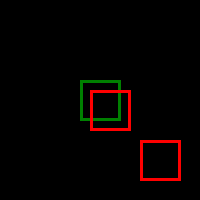

In [6]:
image

## IoU
IoU is used as a metric to decide if a predicted bbox is TP or FP. (1-IOU) can be used as loss as 
- non-negativity: it is always positive value [0-1], minimum value is 0, when gt and pred bbox overlap 100%.
- symmetry
- traingle inequality
- identity of indiscernibles

IoU is defined as intersection between two boxes by union of the two boxes. 

$$
IoU = \frac{(A \cap B)}{(A \cup B)}
$$

$$
IoU_{loss} = 1- IOU
$$

The main drawback with IoU is that the loss is zero when both the boxes have no intersection, means IoU metric cannot distinguish between two boxes which are really far from each other and which are in close by vicinity (but dont overlap).

In [7]:
bbox1 = torch.from_numpy(gt_bbox.corner)
bbox2 = torch.vstack([torch.from_numpy(t.corner) for t in pred_bbox])
print(bbox1.shape, bbox2.shape)
iou=torchvision.ops.box_iou(bbox1, bbox2)
iou

torch.Size([1, 4]) torch.Size([2, 4])


tensor([[0.0000, 0.3913]], dtype=torch.float64)

## GIOU
Generalized IoU solves the problem with IoU by adding a penalty term to the original IoU loss as below

$$
GIoU = IoU - \frac{(C \backslash A \cup B)}{C}
$$

where C is the closest convex shape which contain both A and B (as shown in the figure below). Here, since A and B are rectangle we will choose C shape also to be rectangle

The penality term is defined as the ratio between the area occupied by C excluding A and B and divide by the total area occupied by C

using torchvision, we can calculate the `generalized_box_iou` as follows. 

In [8]:
giou=torchvision.ops.generalized_box_iou(bbox1, bbox2)
giou

tensor([[-0.6800,  0.3113]], dtype=torch.float64)

### pointers on GIoU
- The range is between -1, 1. incase of loss this is betwen (0, 2) as loss is defined as (1-GIoU). 
- GIoU loss ranges from (0, 2), so we can use this as a loss function for bbox regression
- GIoU has non-zero loss for non-overlapping boxes, hence non-zero gradient and better optimization
- GIoU loss reduces as two bboxes comes closer as the overall C tends to A$\cup$B, this again helps in better optimization
- when one bbox is inside another, C becomes the same as A$\cup$B  and hence zero. then GIoU is same as IoU
- For Pred box 1, since there is no intersection, IoU is zero and hence it is -ve.
- For pred box 2, since there is interaction, IoU value is non-zero and hence we have a +ve value. 


Sudo alogrithm for GIoU
- take b1 & b2 boxes for which you want to calculate IoU
- find closest bbox which contains both b1 and b2
- calculate b1 intersection b2 area - [3]
- calculatate b1 union b2 area = (b1 area + b2 area - b1 intersection b2) - [4]
- calulate iou = [3]/[4] - [5]
- calculate C area - [6]
- calculate GIoU = [5] - ([6] - [4])/[6]

In [9]:
def closest_convex_bbox(b1, b2):
    xmin = min([b1.xmin, b2.xmin])
    xmax = max([b1.xmax, b2.xmax])
    ymin = min([b1.ymin, b2.ymin])
    ymax = max([b1.ymax, b2.ymax])
    return Bbox(xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax)

> visualize C bbox with b1 and b2

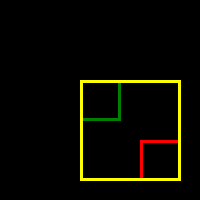

In [10]:
Cbbox = closest_convex_bbox(gt_bbox, pred_bbox[0])
image = Image.fromarray(np.uint8(np.zeros((200, 200, 3))))
image= draw(image, [gt_bbox], color="green")
image= draw(image, [pred_bbox[0]], color="red")
image= draw(image, [Cbbox], color="yellow")
image

> yellow was C bbox  
> red and green our pair of bbox which are of interest

In [11]:
def intersect_iou(bbox1, bbox2):
    x1 = max(bbox1.xmin, bbox2.xmin)
    y1 = max(bbox1.ymin, bbox2.ymin)
    x2 = min(bbox1.xmax, bbox2.xmax)
    y2 = min(bbox1.ymax, bbox2.ymax)
    intersection = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    return intersection

In [12]:
iou = intersect_iou(gt_bbox, pred_bbox[0])
AUB = gt_bbox.area + pred_bbox[0].area - iou
giou = iou - ((Cbbox.area - AUB)/Cbbox.area)
giou

-0.68

> The obtained iou is similar as GIoU we got from `torchvision`

## DIoU
- In the paper [Distance-IoU Loss: Faster and Better Learning for Bounding Box Regression](https://arxiv.org/abs/1911.08287), authors have pointed out several problems with GIoU
- GIoU loss will totally degrade to IoU loss for enclosing bounding box.
- Due to heavily relaying on IoU term, GIoU needs more time for optimization (found empherically in the paper)
- it doesnt work well (or need more iterations) for vertical and horizontal bounding boxes (found through simulation in paper)

The DIOU loss instead tries to converge on the distance between the two center points of ground truth and predicted bounding box. 

$$
R_{DIOU} = \frac{\rho^2(b, b^{gt})}{c^2}
$$

$$
L_{DIoU} = 1 - IOU + R_{DIOU}
$$

- where $\rho(.)$ is the eculidean distance between b and $b^{gt}$
- c is the diagonal length of the samllest enclosing box covering the two boxes

In [33]:
diou=torchvision.ops.distance_box_iou(bbox1, bbox2)
diou

tensor([[-0.3600,  0.3513]], dtype=torch.float64)

> iou is same before   
> calculate the penalty term

In [25]:
def euclidean_distance_between_centers(b1, b2):
    b1x = b1.xmin + (b1.w/2)
    b1y = b1.ymin + (b1.h/2)
    b2x = b2.xmin + (b2.w/2)
    b2y = b2.ymin + (b2.h/2)
    return ((b2y-b1y)**2) + ((b2x-b1x)**2)

In [27]:
rho = euclidean_distance_between_centers(gt_bbox, pred_bbox[0])
c_sqr = ((Cbbox.xmax-Cbbox.xmin)**2) + ((Cbbox.ymax-Cbbox.ymin)**2)
diou_penalty = rho/c_sqr 
diou_penalty

0.36

In [42]:
diou = 1+ iou - l_diou
diou

-0.3599999999999999

## CIOU
Also called as CIOU and mentioned in the same paper as DIOU, C stands for Complete. Where in DIOU we have considered distance between two boxes via penalty term and iou between two boxes as iou term, compelete iou also adds penalty on aspect ratio also.

$$
R_{CIoU} = \frac{\rho^2(b, b^{gt})}{c^2} + \alpha v.
$$

where $R_{CIoU}$ is the penalty term for CIOU

$$
\alpha = \frac{v}{(1-IoU+v)}
$$

where $\alpha$ is the positive trade-off parameter.

$$
v = \frac{4}{\pi^2} (\arctan\frac{w^{gt}}{h^{gt}} - \arctan\frac{w}{h})^2
$$

where v measures the consitency of aspect ratio

$$
L_{CIoU}= 1 - IoU + R_{CIoU}
$$

where $L_{CIoU}$ is the complete loss


In [44]:
ciou=torchvision.ops.complete_box_iou(bbox1, bbox2)
ciou

tensor([[-0.3600,  0.3513]], dtype=torch.float64)

> it is same as DIOU as both our bbox1 aspect ratio and the bbox2 aspect ratio is same

## Metrics
Looking at various algorithms The performance of `CIoU (10% AP75, 6%AP) > DIoU (6% AP75, 4%AP) > GIoU (5% AP75, 2%AP)> IoU`.